<a href="https://colab.research.google.com/github/Aadish1206/Codsoft/blob/main/Spam_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading and Preprocessing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**SMS SPAM DETECTION**

In [6]:
import re
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from nltk.corpus import stopwords
import gensim.downloader as api

df = pd.read_csv('/content/drive/MyDrive/Dataset _Codsfot/SMS Spam/spam.csv', encoding='latin-1')

df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


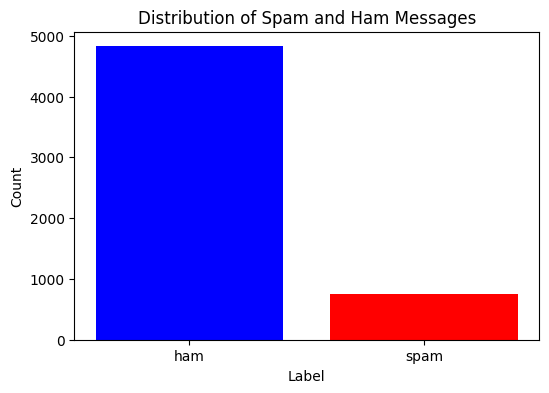

In [7]:
import matplotlib.pyplot as plt


# Visualize the distribution of spam and ham messages
label_counts = df['label'].value_counts()

plt.figure(figsize=(6, 4))
plt.bar(label_counts.index, label_counts.values, color=['blue', 'red'])
plt.title('Distribution of Spam and Ham Messages')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()



## TF-IDF Vectorization

In [8]:
# Display some example messages
print("Example Ham Messages:\n", df[df['label'] == 'ham']['message'].head(), "\n")
print("Example Spam Messages:\n", df[df['label'] == 'spam']['message'].head())


Example Ham Messages:
 0    Go until jurong point, crazy.. Available only ...
1                        Ok lar... Joking wif u oni...
3    U dun say so early hor... U c already then say...
4    Nah I don't think he goes to usf, he lives aro...
6    Even my brother is not like to speak with me. ...
Name: message, dtype: object 

Example Spam Messages:
 2     Free entry in 2 a wkly comp to win FA Cup fina...
5     FreeMsg Hey there darling it's been 3 week's n...
8     WINNER!! As a valued network customer you have...
9     Had your mobile 11 months or more? U R entitle...
11    SIX chances to win CASH! From 100 to 20,000 po...
Name: message, dtype: object


In [9]:
# Data Preprocessing
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.lower()
    return text

df['message'] = df['message'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)


## Model Training and Evaluation - TF-IDF

In [10]:

manual_stopwords = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their',
    'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was',
    'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the',
    'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in',
    'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now'
])

# Convert stopwords to list
manual_stopwords = list(manual_stopwords)


In [11]:

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [12]:

def create_tfidf_pipeline(classifier):
    return Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=manual_stopwords)),
        ('clf', classifier)
    ])


param_grids_tfidf = {
    'nb': {
        'clf': [MultinomialNB()],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__ngram_range': [(1,1), (1,2)]
    },
    'lr': {
        'clf': [LogisticRegression(max_iter=1000)],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'clf__C': [0.1, 1.0, 10.0]
    },
    'svm': {
        'clf': [SVC(kernel='linear')],
        'tfidf__max_df': [0.9, 0.95],
        'tfidf__ngram_range': [(1,1), (1,2)],
        'clf__C': [0.1, 1.0, 10.0]
    }
}


## Model Training and Evaluation - Word Embeddings

In [13]:
word2vec = api.load("glove-wiki-gigaword-100")

def create_word_embeddings(text, model=word2vec):
    words = text.split()
    word_vectors = [model[w] for w in words if w in model]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)


X_train_embeddings = np.vstack(X_train.apply(create_word_embeddings))
X_test_embeddings = np.vstack(X_test.apply(create_word_embeddings))


[==================================================] 100.0% 128.1/128.1MB downloaded


## Word Embeddings Vectorization

In [14]:

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, pos_label=1))
    print("Recall:", recall_score(y_test, y_pred, pos_label=1))
    print("F1 Score:", f1_score(y_test, y_pred, pos_label=1))
    print("="*60)
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


for name, param_grid in param_grids_tfidf.items():
    pipeline = create_tfidf_pipeline(param_grid['clf'][0])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train_encoded)
    evaluate_model(grid_search.best_estimator_, X_test, y_test_encoded, name)


models = {
    'lr': LogisticRegression(max_iter=1000),
    'svm': SVC(kernel='linear')
}

for name, model in models.items():
    model.fit(X_train_embeddings, y_train_encoded)
    evaluate_model(model, X_test_embeddings, y_test_encoded, f"{name} (Word Embeddings)")


Model: nb
Accuracy: 0.9704035874439462
Precision: 1.0
Recall: 0.78
F1 Score: 0.8764044943820225
              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       965
        spam       1.00      0.78      0.88       150

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

Model: lr
Accuracy: 0.9775784753363229
Precision: 0.9699248120300752
Recall: 0.86
F1 Score: 0.9116607773851589
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       965
        spam       0.97      0.86      0.91       150

    accuracy                           0.98      1115
   macro avg       0.97      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Model: svm
Accuracy: 0.9820627802690582
Precision: 0.9452054794520548
Recall: 0.92
F1 Score: 0.9324324324324323
              precision    

## Visualization of Model Results

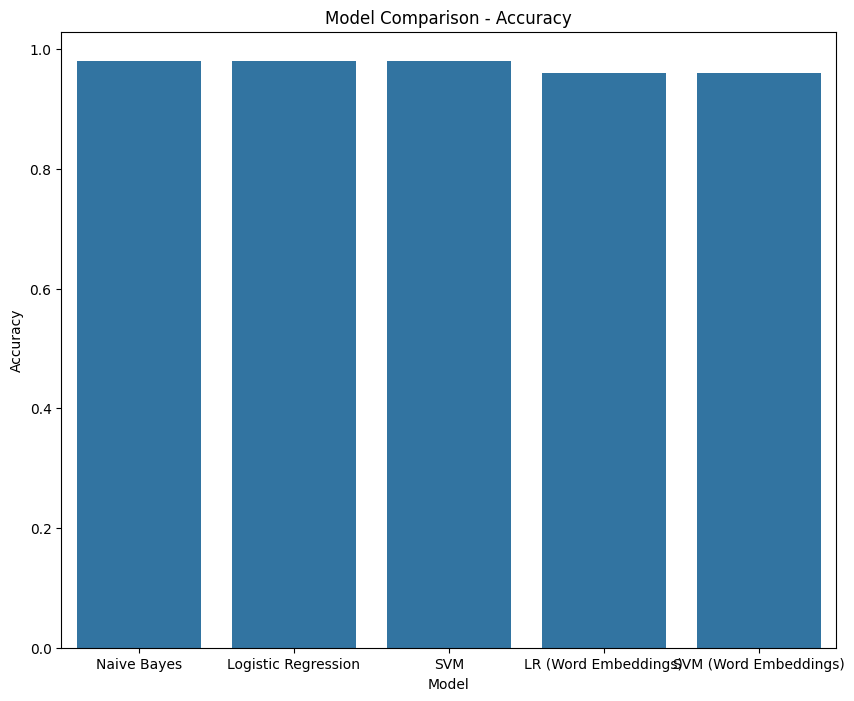

In [16]:
import pandas as pd

# Sample data setup for visualization
data = {
    'Model': ['Naive Bayes', 'Logistic Regression', 'SVM', 'LR (Word Embeddings)', 'SVM (Word Embeddings)'],
    'Accuracy': [0.98, 0.98, 0.98, 0.96, 0.96],
    'Precision': [0.94, 0.97, 0.95, 0.91, 0.87],
    'Recall': [0.92, 0.93, 0.92, 0.79, 0.79],
    'F1 Score': [0.93, 0.95, 0.93, 0.85, 0.83]
}

results_df = pd.DataFrame(data)

# Visualization code
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.title('Model Comparison - Accuracy')
plt.show()
